# Mod 2 Project
Use multivariate linear regression to predict housing prices for the King County, WA Dataset

https://en.wikipedia.org/wiki/King_County,_Washington

https://www.kingcounty.gov/depts/assessor.aspx

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm

## Read in Data

In [2]:
df = pd.read_csv('datasets/kc_house_data.csv')

## EDA

### Initial Review

**Data Summary**
* 21 columns
* 21597 rows
* columns that contain NaN
    * waterfront
    * view
    * yr_renovated
* columns with object data that should be another type
    * date - convert to datetime
    * sqft_basement - convert to numeric


In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [5]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


### Convert data types

#### Assign new dataframe variable for the cleaned data

In [6]:
df_clean = df.copy(deep=True)

#### sqft_basement

In [7]:
df_clean.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
243.0         1
935.0         1
1798.0        1
2050.0        1
2570.0        1
Name: sqft_basement, Length: 304, dtype: int64

**sqft_basement** contains a ? for 454 rows.

Will convert that to 0 b/c unknown basement should be considered no basement, unless new data is received later

In [8]:
df_clean.loc[df_clean.sqft_basement == '?', 'sqft_basement'] = '0'

In [9]:
df_clean.sqft_basement = df_clean.sqft_basement.astype(float)

In [10]:
df_clean.sqft_basement.value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
915.0         1
295.0         1
1281.0        1
2130.0        1
906.0         1
Name: sqft_basement, Length: 303, dtype: int64

#### date

In [11]:
df_clean.date = pd.to_datetime(df.date)

In [12]:
df_clean.date.describe()

count                   21597
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

### Review and deal with NaN type values

#### waterfront

In [13]:
df_clean.waterfront.describe()

count    19221.000000
mean         0.007596
std          0.086825
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: waterfront, dtype: float64

is a binary category, will treat rows with NaN as 0, no view to a waterfront b/c
it is the more conservative choice

In [14]:
df_clean.waterfront.fillna(0.0, inplace=True)

In [15]:
df_clean.waterfront.value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

#### view

In [16]:
df_clean.view.describe()

count    21534.000000
mean         0.233863
std          0.765686
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: view, dtype: float64

In [17]:
df_clean.view.value_counts(dropna=False)

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
NaN       63
Name: view, dtype: int64

The category has valid values of 0,1,2,3,4, presumably the number of times the property has been viewed,
although it seems strange that the max is 4, so the data likely was transformed into 4 bins
potentially quartiles.

Since most of the houses have a value of 0.0, I will replace the NaN's with 0.0

In [18]:
df_clean.view.fillna(0.0, inplace=True)

#### yr_renovated

In [19]:
df_clean.yr_renovated.describe()

count    17755.000000
mean        83.636778
std        399.946414
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

In [20]:
df_clean.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

besides NaN, most of the data is set to 0.0, which can be taken to mean there is no data on a renovation or 
that the house was never renovated.

The Nan's will be set to 0.0, since that seems to be the default value, and no renovation is 
equivalent to no known renovation.

In [21]:
df_clean.yr_renovated.fillna(0.0, inplace=True)

#### look for other Nan type values

In [22]:
for col in df_clean.columns[1:]:
    print(col)
    print(sorted(df_clean[col].unique()))
    print('')
    print('')

date
[numpy.datetime64('2014-05-02T00:00:00.000000000'), numpy.datetime64('2014-05-03T00:00:00.000000000'), numpy.datetime64('2014-05-04T00:00:00.000000000'), numpy.datetime64('2014-05-05T00:00:00.000000000'), numpy.datetime64('2014-05-06T00:00:00.000000000'), numpy.datetime64('2014-05-07T00:00:00.000000000'), numpy.datetime64('2014-05-08T00:00:00.000000000'), numpy.datetime64('2014-05-09T00:00:00.000000000'), numpy.datetime64('2014-05-10T00:00:00.000000000'), numpy.datetime64('2014-05-11T00:00:00.000000000'), numpy.datetime64('2014-05-12T00:00:00.000000000'), numpy.datetime64('2014-05-13T00:00:00.000000000'), numpy.datetime64('2014-05-14T00:00:00.000000000'), numpy.datetime64('2014-05-15T00:00:00.000000000'), numpy.datetime64('2014-05-16T00:00:00.000000000'), numpy.datetime64('2014-05-17T00:00:00.000000000'), numpy.datetime64('2014-05-18T00:00:00.000000000'), numpy.datetime64('2014-05-19T00:00:00.000000000'), numpy.datetime64('2014-05-20T00:00:00.000000000'), numpy.datetime64('2014-05

In [23]:
for col in df_clean.columns[1:]:
    print(col)
    print(df_clean[col].min())
    print(df_clean[col].max())
    print('')
    print('')

date
2014-05-02 00:00:00
2015-05-27 00:00:00


price
78000.0
7700000.0


bedrooms
1
33


bathrooms
0.5
8.0


sqft_living
370
13540


sqft_lot
520
1651359


floors
1.0
3.5


waterfront
0.0
1.0


view
0.0
4.0


condition
1
5


grade
3
13


sqft_above
370
9410


sqft_basement
0.0
4820.0


yr_built
1900
2015


yr_renovated
0.0
2015.0


zipcode
98001
98199


lat
47.1559
47.7776


long
-122.51899999999999
-121.315


sqft_living15
399
6210


sqft_lot15
651
871200




### create pre-processing function

based upon the datatype conversions, and NaN value processing above

In [24]:
def pre_process_data(data):
    """Convert String columns to numeric/data, and fill Nan values"""
    # type conversion
    data.loc[data.sqft_basement == '?', 'sqft_basement'] = '0'
    data.sqft_basement = data.sqft_basement.astype(float)
    
    data.date = pd.to_datetime(data.date)
    
    # fill Nan values
    data.waterfront.fillna(0.0, inplace=True)
    data.view.fillna(0.0, inplace=True)
    data.yr_renovated.fillna(0.0, inplace=True)
    
    return data

### Look at Sale Dates

In [25]:
df_clean.date.nunique()

372

In [26]:
df_clean.date.describe()

count                   21597
unique                    372
top       2014-06-23 00:00:00
freq                      142
first     2014-05-02 00:00:00
last      2015-05-27 00:00:00
Name: date, dtype: object

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


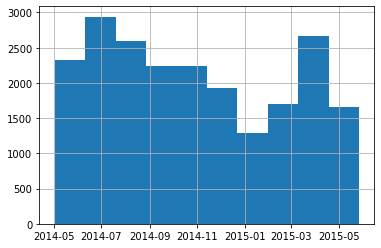

In [27]:
df_clean.date.hist()

In the time frame of the house sales in the dataset, there are 391 days and there were sales on 372 of those days.

Sales took a dip in early 2015.  The dataset is from King County in Washington state, so the cold weather probably depressed sales.

Sales in 2015 don't look to be on the same trend as in 2014, to find out why it would be good to look at other economic data.

### Look at yr_renovated

In [28]:
houses_with_renovations_df = df_clean[df_clean.yr_renovated != 0]

In [29]:
houses_with_renovations_df.yr_renovated.describe()

count     744.000000
mean     1995.928763
std        15.599946
min      1934.000000
25%      1987.000000
50%      2000.000000
75%      2007.250000
max      2015.000000
Name: yr_renovated, dtype: float64

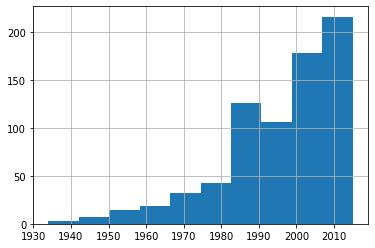

In [30]:
houses_with_renovations_df.yr_renovated.hist()

In [31]:
recent_renos = houses_with_renovations_df[houses_with_renovations_df.yr_renovated >= 2013]

In [32]:
recent_renos

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
158,8029200135,2014-11-13,247000.0,3,2.00,1270,7198,1.5,0.0,0.0,...,7,1270,0.0,1916,2013.0,98022,47.2086,-121.996,1160,7198
379,7132300695,2015-04-21,435000.0,3,1.50,1300,3348,1.5,0.0,0.0,...,7,1300,0.0,1904,2014.0,98144,47.5920,-122.307,1590,2577
435,2268400350,2014-09-16,749000.0,4,2.50,1710,9627,1.0,0.0,0.0,...,9,1440,270.0,1976,2014.0,98006,47.5590,-122.164,2140,9131
586,7942601895,2014-08-19,640000.0,3,2.50,2160,4000,1.5,0.0,0.0,...,8,1960,200.0,1903,2013.0,98122,47.6045,-122.307,2160,5120
890,1962200435,2014-11-10,1010000.0,4,1.00,1820,5400,1.5,0.0,0.0,...,8,1820,0.0,1923,2014.0,98102,47.6476,-122.318,1820,5400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19429,582000644,2015-05-01,872500.0,4,2.00,1990,6000,1.0,0.0,0.0,...,9,1260,730.0,1956,2015.0,98199,47.6515,-122.397,1770,6000
19472,8075400530,2014-06-27,234000.0,4,1.00,1390,18000,1.0,0.0,0.0,...,7,1390,0.0,1955,2013.0,98032,47.3885,-122.284,1390,18000
19506,4137020820,2014-10-27,268000.0,4,3.00,1840,7510,2.0,0.0,0.0,...,8,1840,0.0,1988,2013.0,98092,47.2595,-122.218,1650,7957
19577,421059018,2014-11-04,257000.0,3,1.75,1397,18000,1.0,0.0,0.0,...,7,1397,0.0,1965,2014.0,98092,47.3388,-122.166,1950,31294


### Look at ID

In [33]:
df_clean.id.nunique()

21420

In [34]:
id_df = df_clean.id.value_counts().to_frame()
id_df

,id
795000620,3
1825069031,2
2019200220,2
7129304540,2
1781500435,2
...,...
7812801125,1
4364700875,1
3021059276,1
880000205,1


In [35]:
id_df[id_df.id == 2].count()

id    175
dtype: int64

There were 175 houses that sold twice in the year and one that sold three times.  These would have to be classified as flips.  Houses with recent renovations might be flips, but it would be hard to tell without prior sale data.

**Look to see what changed if anything to the flipped houses**

### Look at Distributions of data

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


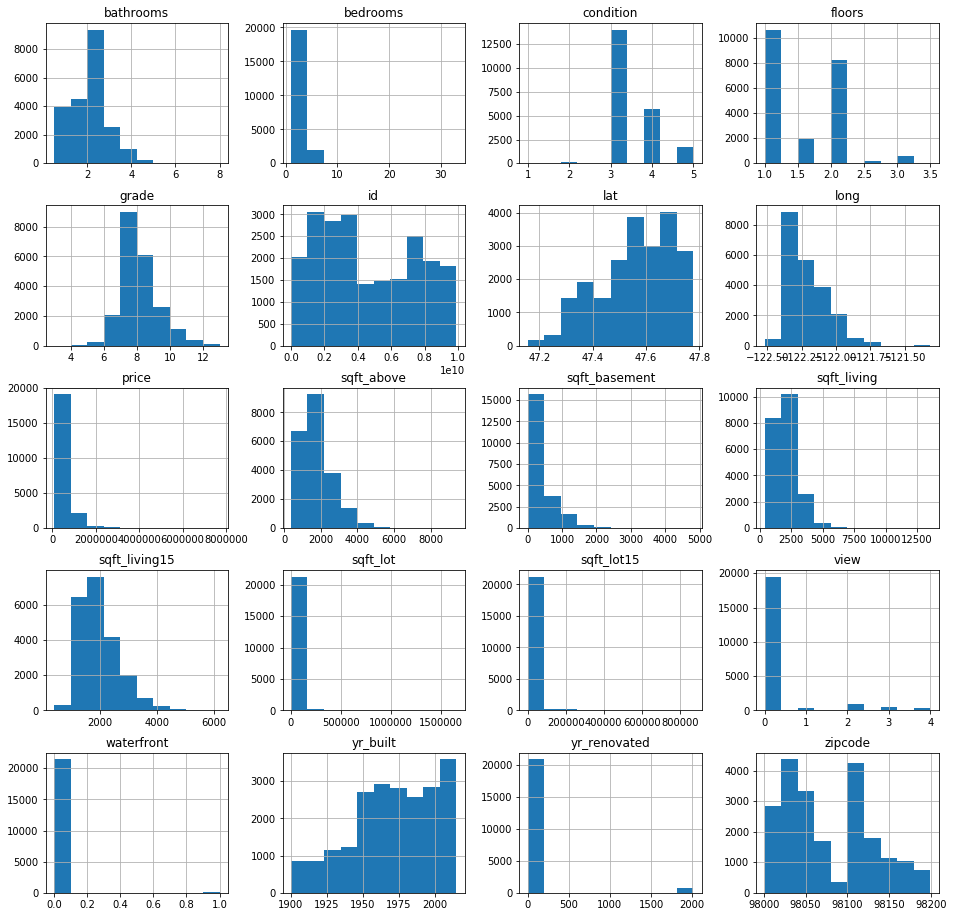

In [36]:
fig = plt.figure(figsize=(16,16))
ax = fig.gca()
df_clean.hist(ax=ax);

**Determine columns with continuous data**

In [37]:
cont_data_cols = ['sqft_above', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
                 'bathrooms', 'bedrooms',  'floors', 'grade']

**Determine columns with category data**

In [38]:
cat_data_cols = ['date',  'lat', 'long', 'condition',
                'sqft_basement', 'view', 'waterfront', 'yr_built', 'yr_renovated', 'zipcode']

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


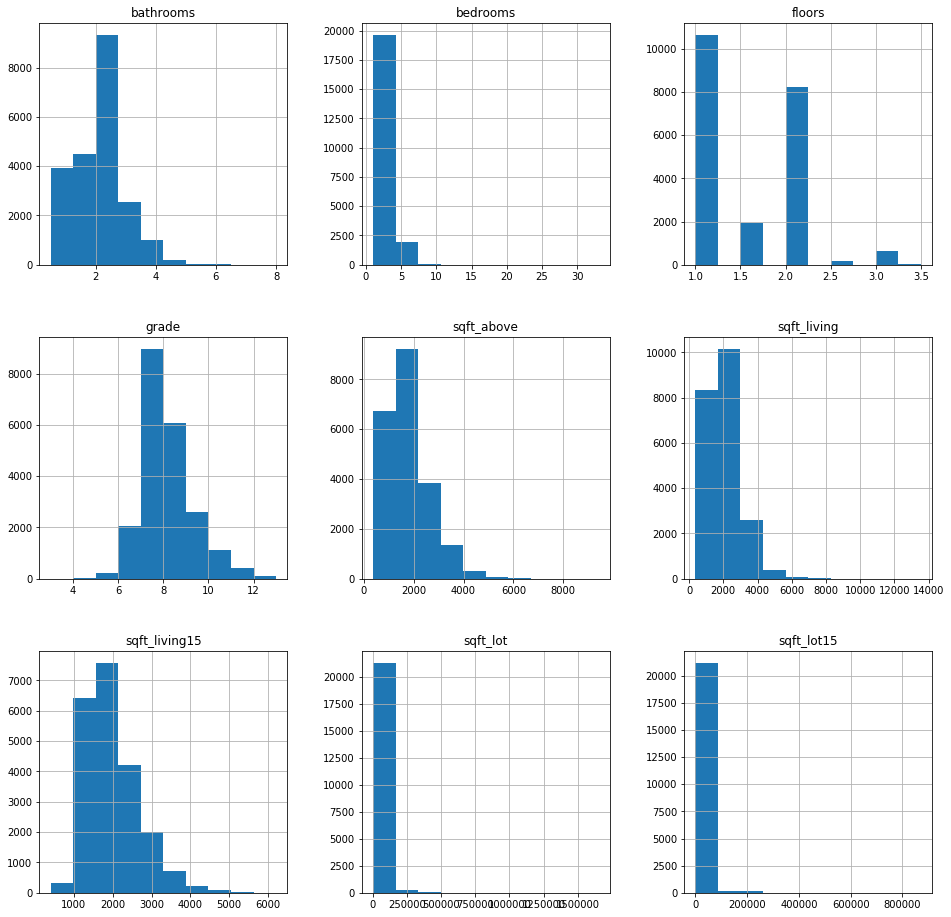

In [39]:
fig = plt.figure(figsize=(16,16))
ax = fig.gca()
df_clean[cont_data_cols].hist(ax=ax);

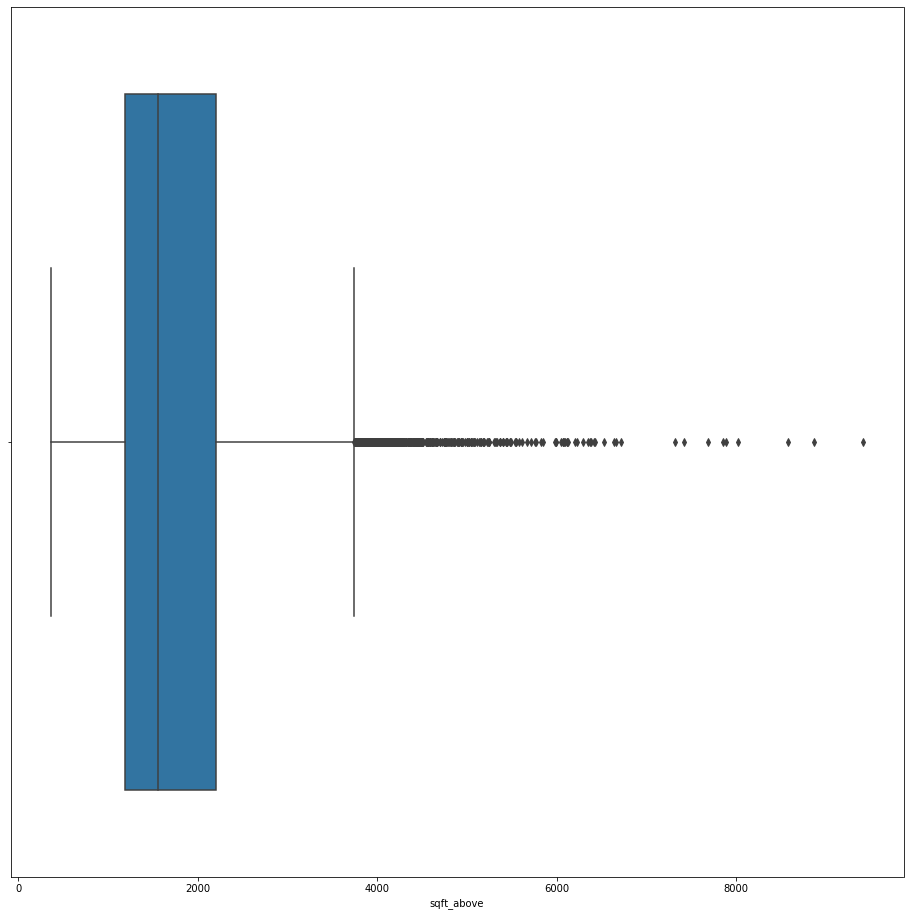

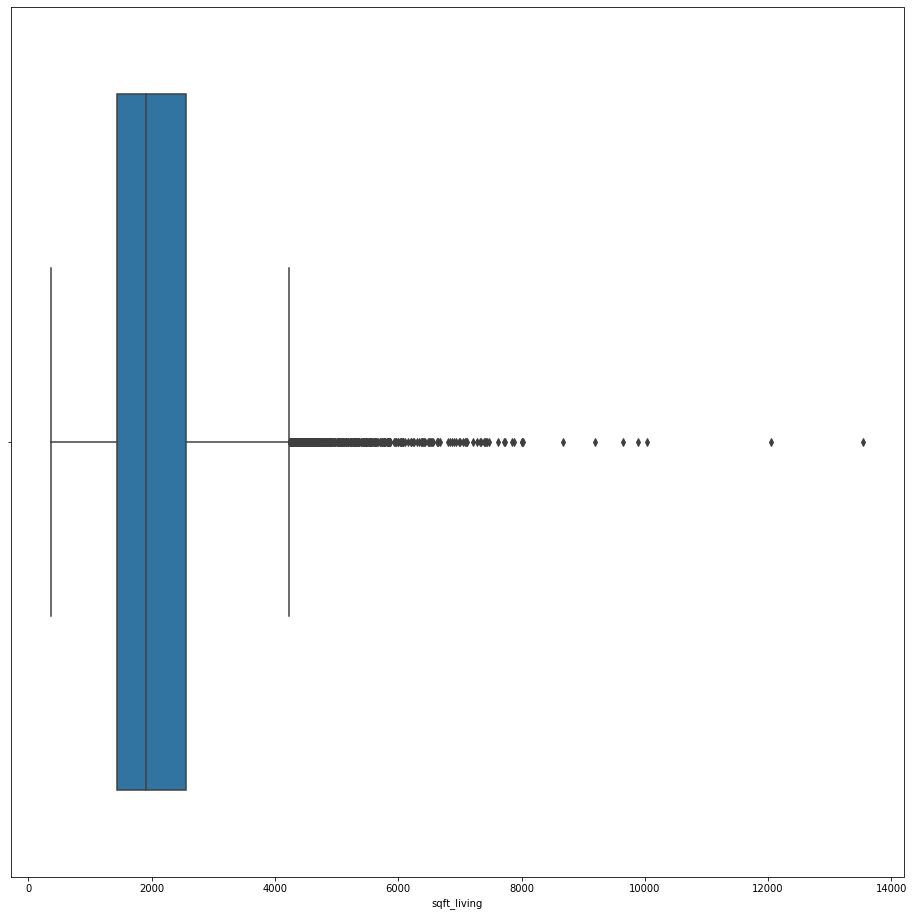

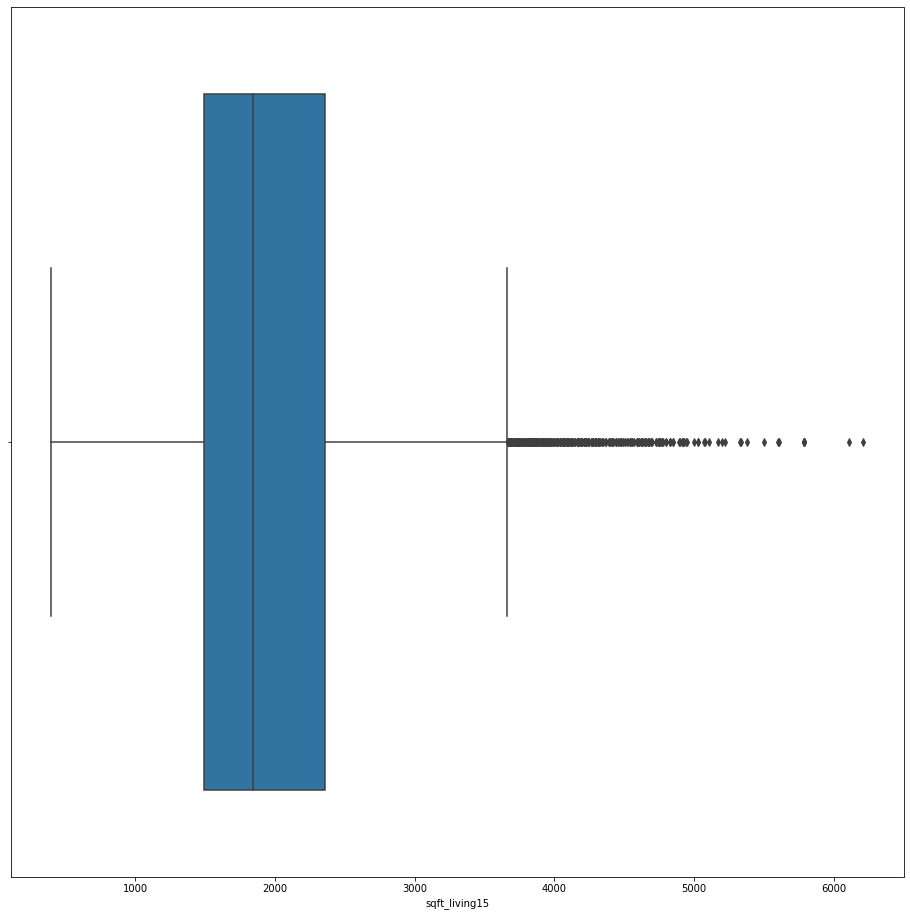

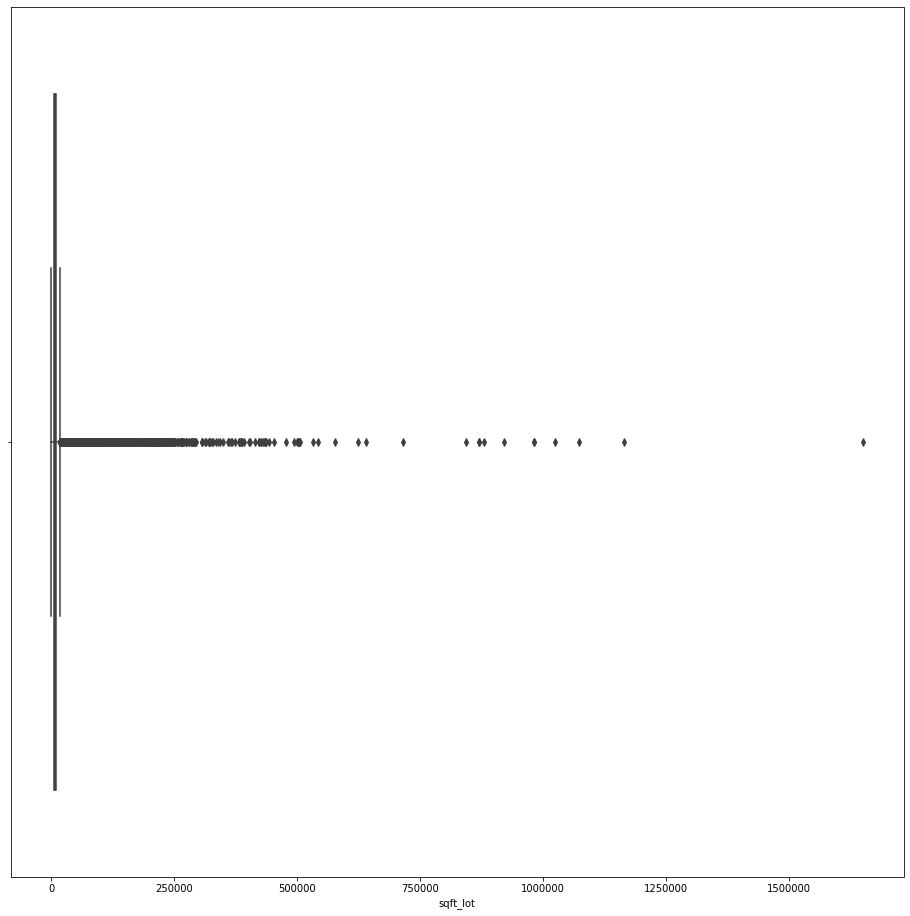

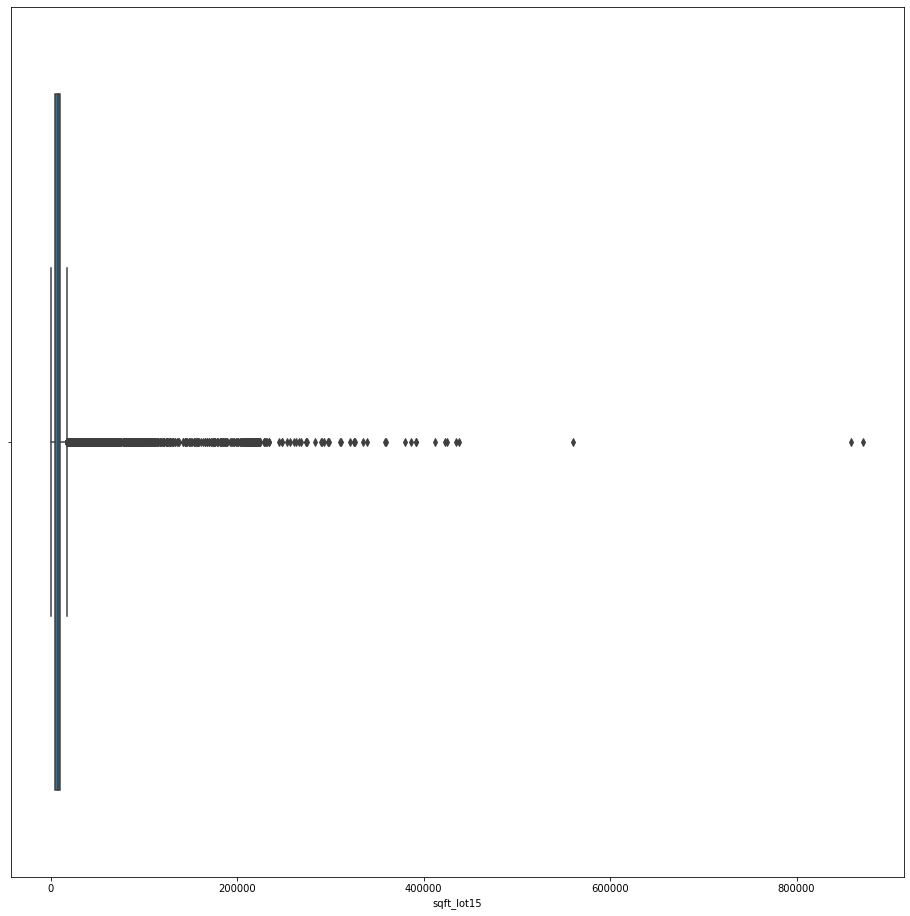

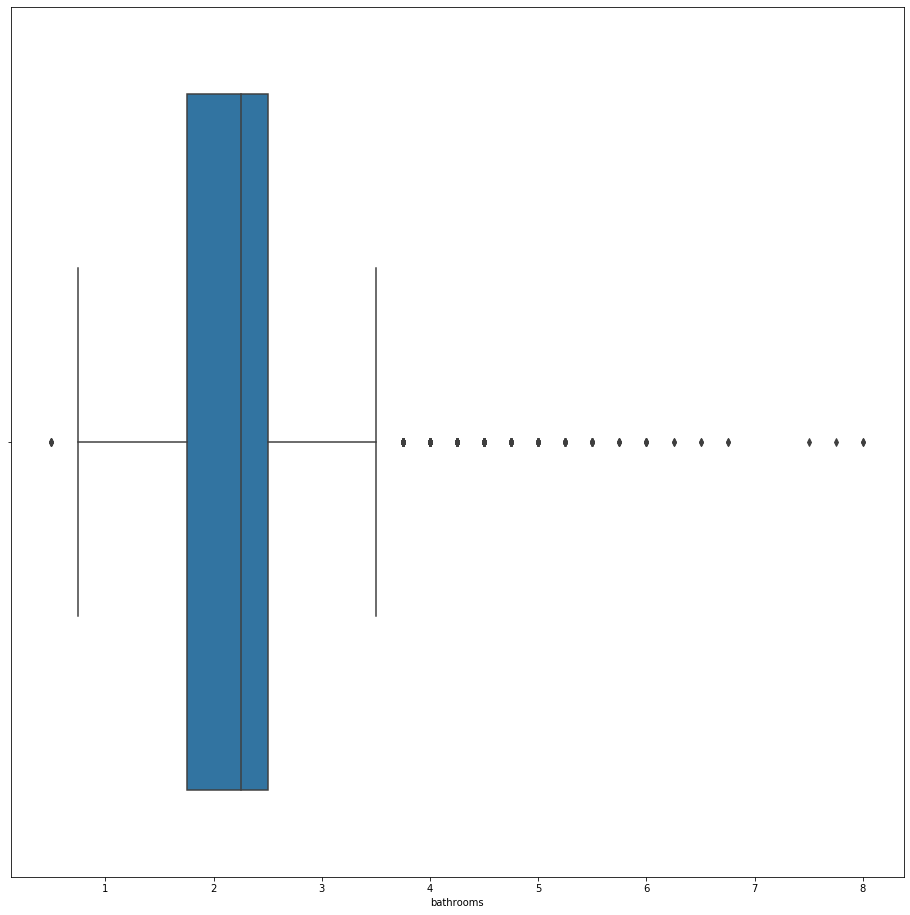

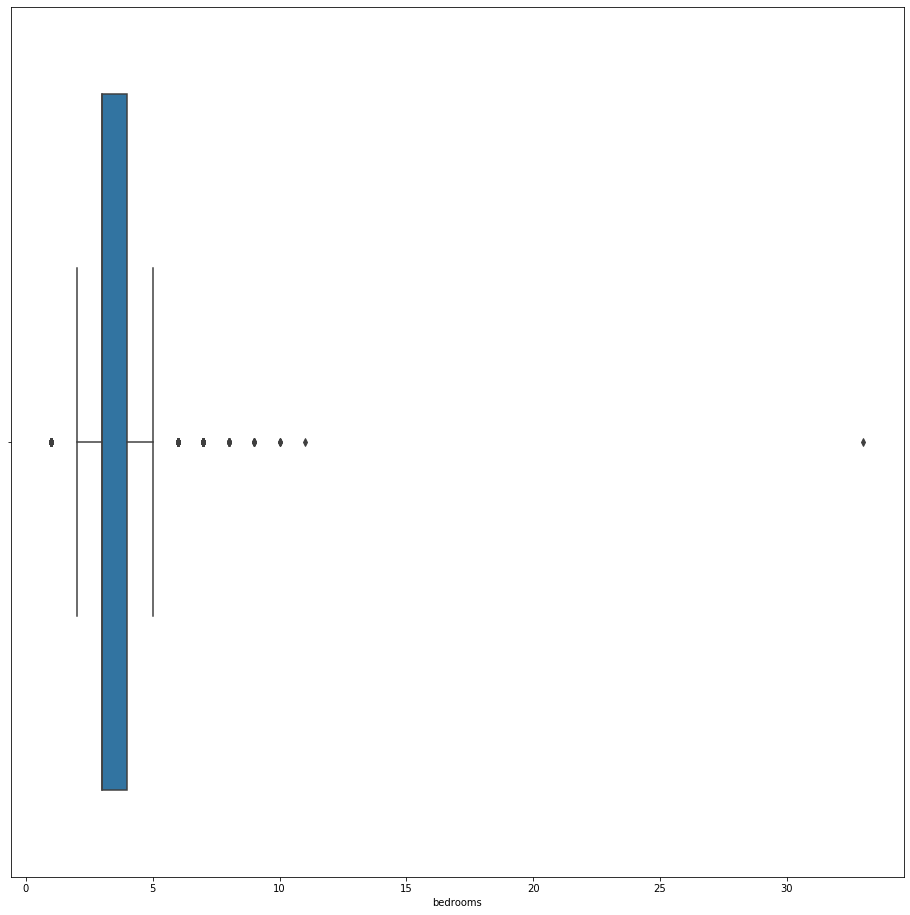

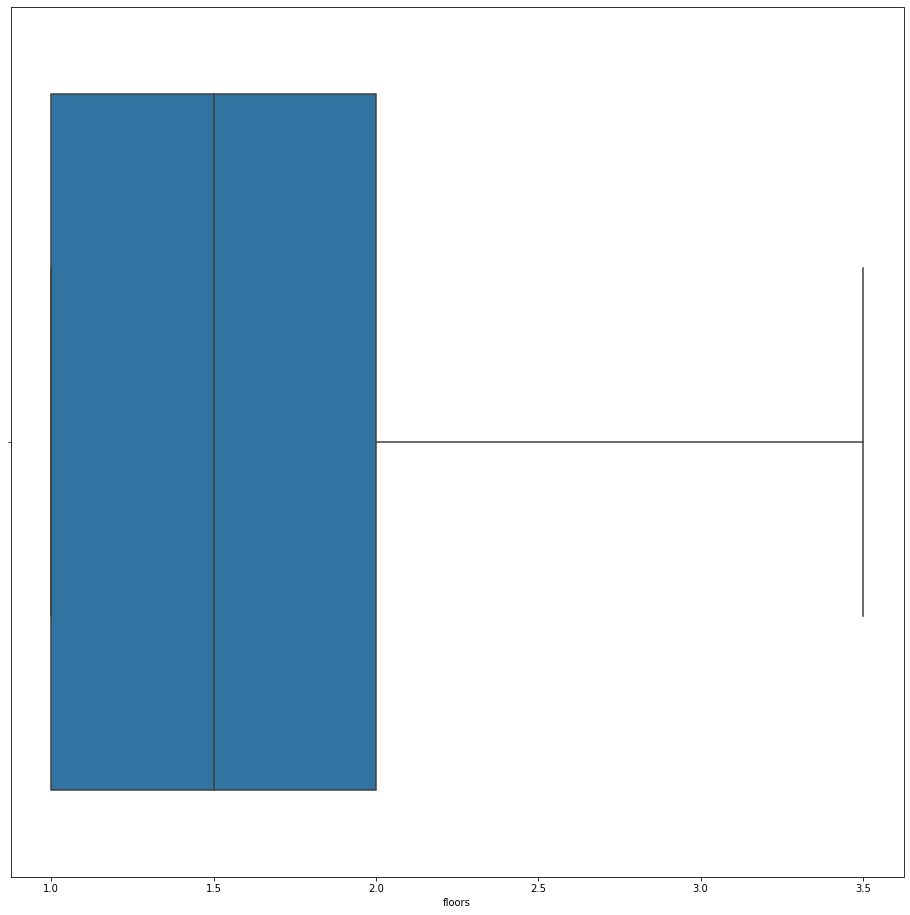

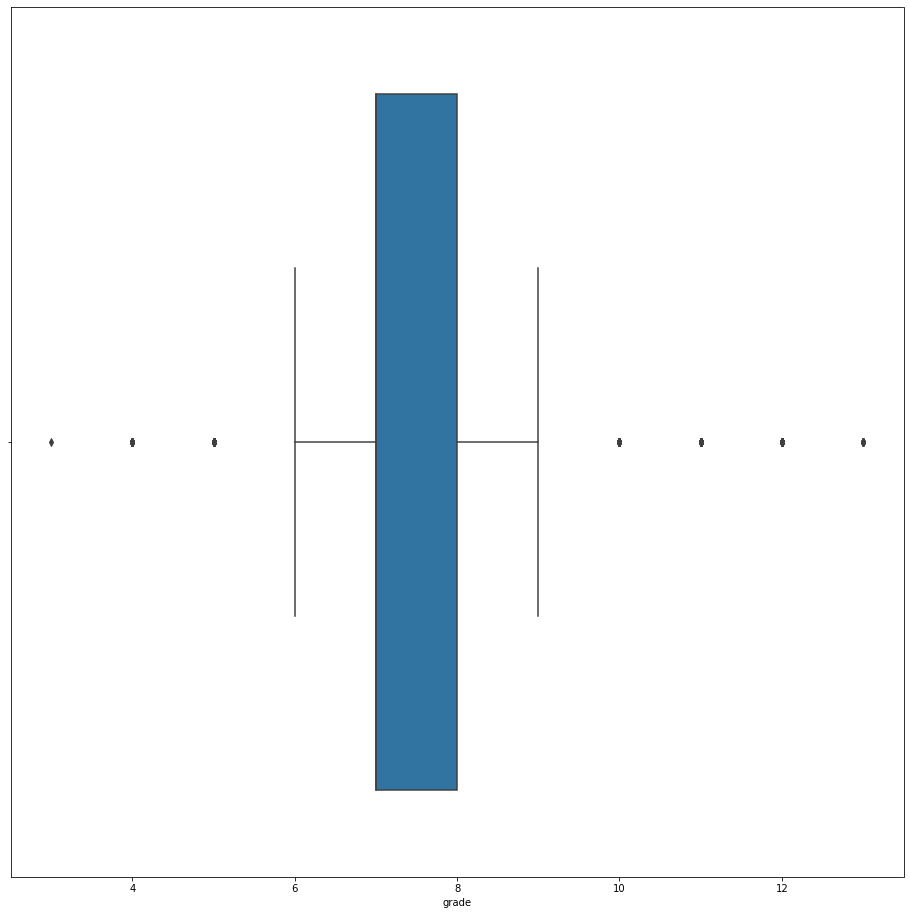

In [40]:
for col in df_clean[cont_data_cols]:
    fig = plt.figure(figsize=(16,16))
    sns.boxplot(df_clean[col])
    plt.show()

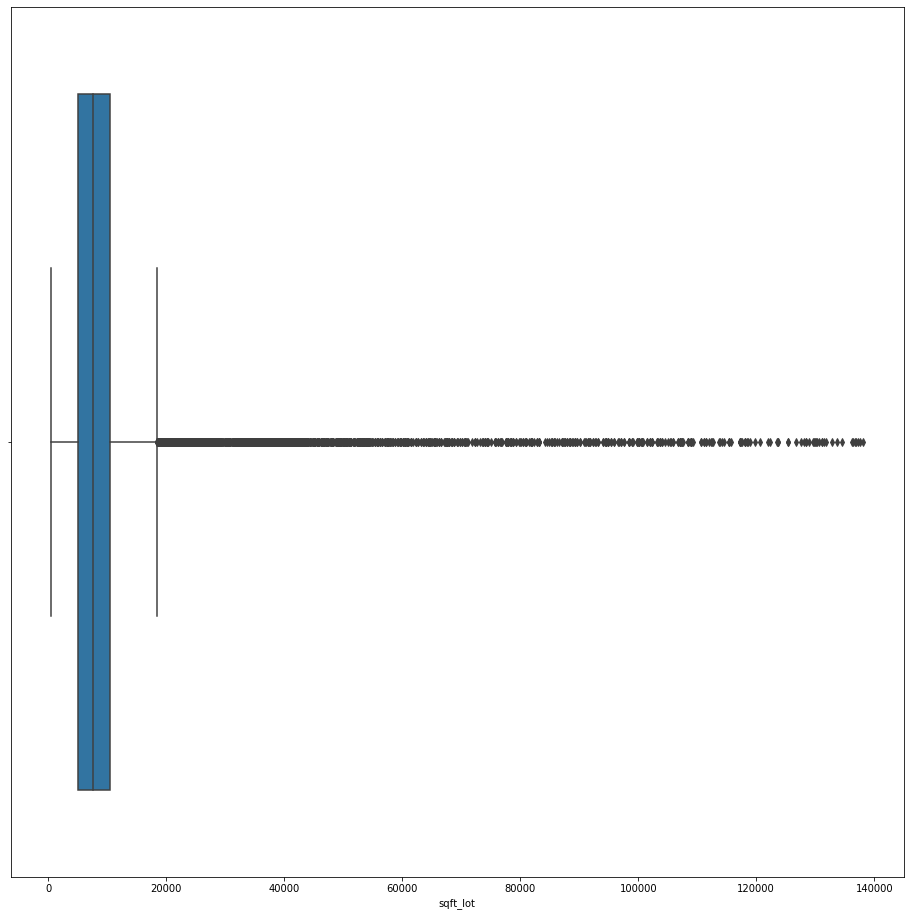

In [41]:
# look at the sqft_lot data without any data 3 std or more from the mean
sqft_lot = df_clean[np.abs(df_clean.sqft_lot-df_clean.sqft_lot.mean())<=(3*df_clean.sqft_lot.std())]

fig = plt.figure(figsize=(16,16))
sns.boxplot(sqft_lot.sqft_lot)

**Analysis of the continuous data cols**
* All are skewed right
* All have some positive outliers
* sqft_lot and sqft_lot_15 have some extreme positive outliers

### Look at relation of continuous data features to the target and each other

#### Visualizations

In [42]:
cont_data_cols_plus_target = cont_data_cols + ['price']

In [43]:
# sns.pairplot(df_clean[cont_data_cols_plus_target])

In [44]:
epsilon = 1
log_df = np.log(df_clean[cont_data_cols] + epsilon)
log_df['price'] = df_clean.price

In [45]:
log_df

,sqft_above,sqft_living,sqft_living15,sqft_lot,sqft_lot15,bathrooms,bedrooms,floors,grade,price
0,7.074117,7.074117,7.201171,8.639588,8.639588,0.693147,1.386294,0.693147,2.079442,221900.0
1,7.682943,7.852050,7.433075,8.887791,8.941153,1.178655,1.386294,1.098612,2.079442,538000.0
2,6.647688,6.647688,7.908755,9.210440,8.995041,0.693147,1.098612,0.693147,1.945910,180000.0
3,6.957497,7.581210,7.215975,8.517393,8.517393,1.386294,1.609438,0.693147,2.079442,604000.0
4,7.427144,7.427144,7.496097,8.997271,8.923191,1.098612,1.386294,0.693147,2.197225,510000.0
...,...,...,...,...,...,...,...,...,...,...
21592,7.333676,7.333676,7.333676,7.031741,7.319865,1.252763,1.386294,1.386294,2.197225,360000.0
21593,7.745436,7.745436,7.512618,8.668024,8.881975,1.252763,1.609438,1.098612,2.197225,400000.0
21594,6.928538,6.928538,6.928538,7.208600,7.604894,0.559616,1.098612,1.098612,2.079442,402101.0
21595,7.378384,7.378384,7.252054,7.778630,7.160846,1.252763,1.386294,1.098612,2.197225,400000.0


In [46]:
# sns.pairplot(log_df)

In [47]:
def correlation_triangle(d):

    # Compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [48]:
df_clean[cont_data_cols_plus_target].corr()

,sqft_above,sqft_living,sqft_living15,sqft_lot,sqft_lot15,bathrooms,bedrooms,floors,grade,price
sqft_above,1.000000,0.876448,0.731767,0.184139,0.195077,0.686668,0.479386,0.523989,0.756073,0.605368
sqft_living,0.876448,1.000000,0.756402,0.173453,0.184342,0.755758,0.578212,0.353953,0.762779,0.701917
sqft_living15,0.731767,0.756402,1.000000,0.144763,0.183515,0.569884,0.393406,0.280102,0.713867,0.585241
sqft_lot,0.184139,0.173453,0.144763,1.000000,0.718204,0.088373,0.032471,-0.004814,0.114731,0.089876
sqft_lot15,0.195077,0.184342,0.183515,0.718204,1.000000,0.088303,0.030690,-0.010722,0.120981,0.082845
bathrooms,0.686668,0.755758,0.569884,0.088373,0.088303,1.000000,0.514508,0.502582,0.665838,0.525906
bedrooms,0.479386,0.578212,0.393406,0.032471,0.030690,0.514508,1.000000,0.177944,0.356563,0.308787
floors,0.523989,0.353953,0.280102,-0.004814,-0.010722,0.502582,0.177944,1.000000,0.458794,0.256804
grade,0.756073,0.762779,0.713867,0.114731,0.120981,0.665838,0.356563,0.458794,1.000000,0.667951
price,0.605368,0.701917,0.585241,0.089876,0.082845,0.525906,0.308787,0.256804,0.667951,1.000000


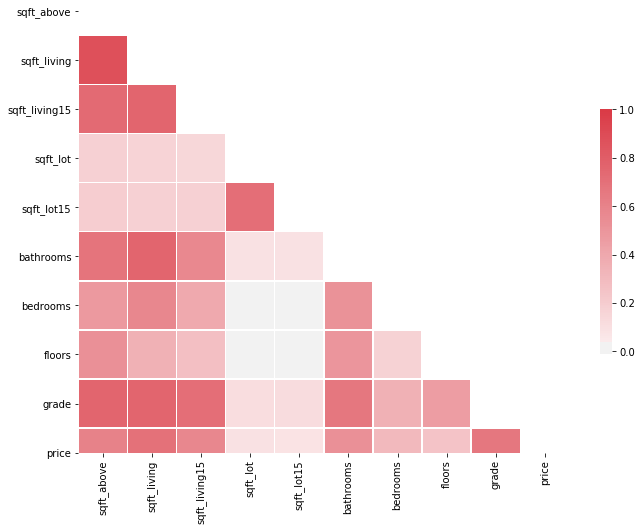

In [49]:
correlation_triangle(df_clean[cont_data_cols_plus_target])

In [50]:
log_df.corr()

,sqft_above,sqft_living,sqft_living15,sqft_lot,sqft_lot15,bathrooms,bedrooms,floors,grade,price
sqft_above,1.000000,0.864984,0.713127,0.318673,0.298709,0.692736,0.546354,0.569894,0.739808,0.542715
sqft_living,0.864984,1.000000,0.746858,0.325997,0.303074,0.765945,0.649916,0.386495,0.744838,0.611892
sqft_living15,0.713127,0.746858,1.000000,0.363743,0.373620,0.575606,0.428032,0.293783,0.683435,0.543855
sqft_lot,0.318673,0.325997,0.363743,1.000000,0.918664,0.089567,0.196680,-0.220120,0.166507,0.161565
sqft_lot15,0.298709,0.303074,0.373620,0.918664,1.000000,0.083001,0.175697,-0.210924,0.167745,0.147916
bathrooms,0.692736,0.765945,0.575606,0.089567,0.083001,1.000000,0.535222,0.515935,0.663224,0.478753
bedrooms,0.546354,0.649916,0.428032,0.196680,0.175697,0.535222,1.000000,0.206132,0.390485,0.305532
floors,0.569894,0.386495,0.293783,-0.220120,-0.210924,0.515935,0.206132,1.000000,0.471483,0.264078
grade,0.739808,0.744838,0.683435,0.166507,0.167745,0.663224,0.390485,0.471483,1.000000,0.639334
price,0.542715,0.611892,0.543855,0.161565,0.147916,0.478753,0.305532,0.264078,0.639334,1.000000


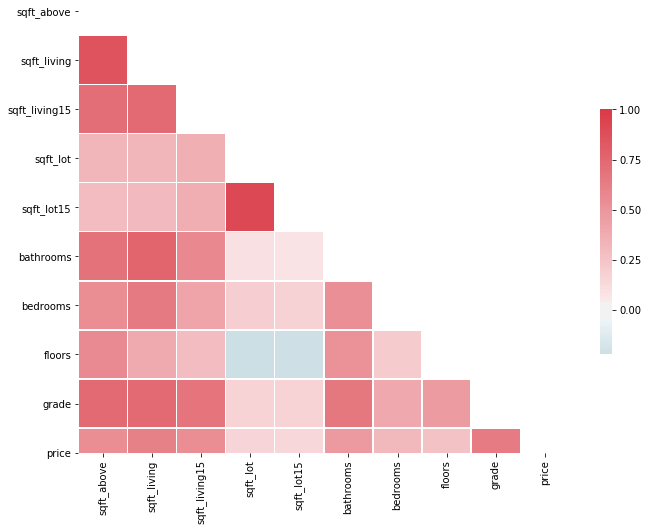

In [51]:
correlation_triangle(log_df)

#### Analysis

The continuous features may benefit from a transformation to make them more normal, 
but a log transformation would have mixed results regarding their correlation with
the target, with 3 strongest going down and 2 weakest going up.

There is is a very strong correlation > 0.87 between 
* sqft_living and sqft_above

There is a strong correlation > 0.7 between several variables
* sqft_living15 and sqft_above
* sqft_living15 and sqft_living
* sqft_lot and sqft_lot15

A log transform maintains the above correlations except one.
* sqft_lot and sqft_lot15 goes from a strong to a very strong correlation

Another thing to note, is regarding sqft_living vs. price.  Their correlation appears to go
from linear to quadratic when the log transformation is done.

**sqft_above should be dropped**

## Categorical Vars

In [52]:
cat_data_cols

['date',
 'lat',
 'long',
 'condition',
 'sqft_basement',
 'view',
 'waterfront',
 'yr_built',
 'yr_renovated',
 'zipcode']

In [53]:
location_cat_data_cols = ['lat', 'long', 'zipcode']
simple_cat_data_cols = ['view','waterfront']
complex_cat_data_cols = ['date', 'sqft_basement', 'yr_built', 'yr_renovated', 'condition']

In [54]:
len(cat_data_cols) == len(location_cat_data_cols) + len(simple_cat_data_cols) + len(complex_cat_data_cols)

True

In [55]:
lb_make = LabelEncoder()

In [56]:
def df_ohe(data, col, prefix):
    dummies = pd.get_dummies(data[col],
                            prefix=prefix,
                            drop_first=True)
    data = data.drop(col, axis=1)
    data = pd.concat([data, dummies], axis=1)
    return data

In [57]:
def make_category(data, col, suffix='_encoded'):
    data[col] = data[col].astype('category')
    data[col+suffix] = lb_make.fit_transform(data[col])
    data = data.drop(col, axis=1)
    data = df_ohe(data, col+suffix, col+'_')
    return data

In [58]:
for col in simple_cat_data_cols:
    df_clean = make_category(df_clean, col)

## Split the Data into train/test

In [59]:
y = df_clean.price
X = df_clean.drop('price', axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Simple Model

This model will only contain the continuous features

### Define feature sets

In [61]:
X_train_cont_features = X_train[cont_data_cols]
X_test_cont_features = X_test[cont_data_cols]

### Linear Regression sklearn

In [62]:
def lin_reg_sklearn(X_train, X_test, y_train, y_test):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    y_hat_train = lin_reg.predict(X_train)
    y_hat_test = lin_reg.predict(X_test)

    y_hat_train = lin_reg.predict(X_train)
    y_hat_test = lin_reg.predict(X_test)

    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)

    print(f'Training Set RMSE: {np.sqrt(train_mse)}')
    print(f'Test Set RMSE: {np.sqrt(test_mse)}')

    MSE = make_scorer(mean_squared_error)

    cv_rmse = np.sqrt(np.mean(cross_val_score(lin_reg, X_train, 
                                                    y_train, cv=10,
                                                   scoring=MSE)))
    print(f'Cross Val RMSE: {cv_rmse}')

In [63]:
# drop sqft_living
X_train_cont_features = X_train_cont_features.drop('sqft_living', axis=1)
X_test_cont_features = X_test_cont_features.drop('sqft_living', axis=1)

X_train_cont_features = X_train_cont_features.drop('sqft_lot', axis=1)
X_test_cont_features = X_test_cont_features.drop('sqft_lot', axis=1)

In [64]:
lin_reg_sklearn(X_train_cont_features, X_test_cont_features, y_train, y_test)

Training Set RMSE: 263087.89106872724
Test Set RMSE: 253729.82344326557
Cross Val RMSE: 263734.4624240192


### Linear Regression statsmodels

In [65]:
X_train_cont_features_int = sm.add_constant(X_train_cont_features)
model_cont_features = sm.OLS(y_train, X_train_cont_features_int).fit()
model_cont_features.summary()

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     2381.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:08:47   Log-Likelihood:            -2.4014e+05
No. Observations:               17277   AIC:                         4.803e+05
Df Residuals:                   17269   BIC:                         4.804e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.857e+05   1.77e+04    -38.747      0.000    -7.2e+05   -6.51e+05
sqft_above       99.6473      4.721     21.106      0.000      90.393     108.901
sqft_living15    63.5134      4.764     13.332      0.000      54.175      72.852
sqft_lot15       -0.6115      0.078     -7.886      0.000      -0.763      -0.459
bathrooms       5.73e+04   4115.217     13.924      0.000    4.92e+04    6.54e+04
bedrooms       -1.18e+04   2612.975     -4.518      0.000   -1.69e+04   -6683.198
floors        -9.285e+04   4724.269    -19.655      0.000   -1.02e+05   -8.36e+04
grade          1.288e+05   2970.171     43.381      0.000    1.23e+05    1.35e+05
==============================================================================
Omnibus:                    15297.849   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1435874.952
Skew:                           3.846   Prob(JB):                         0.00
Kurtosis:                      46.994   Cond. No.                     2.66e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analyze the residuals

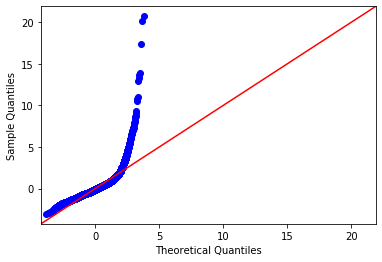

In [66]:
sm.graphics.qqplot(model_cont_features.resid, line='45', fit=True);

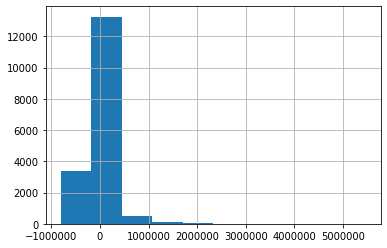

In [67]:
model_cont_features.resid.hist()

The residuals do not have a normal distribution, they are skewed to the right, as is shown in the q-q plot and the histogram.

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


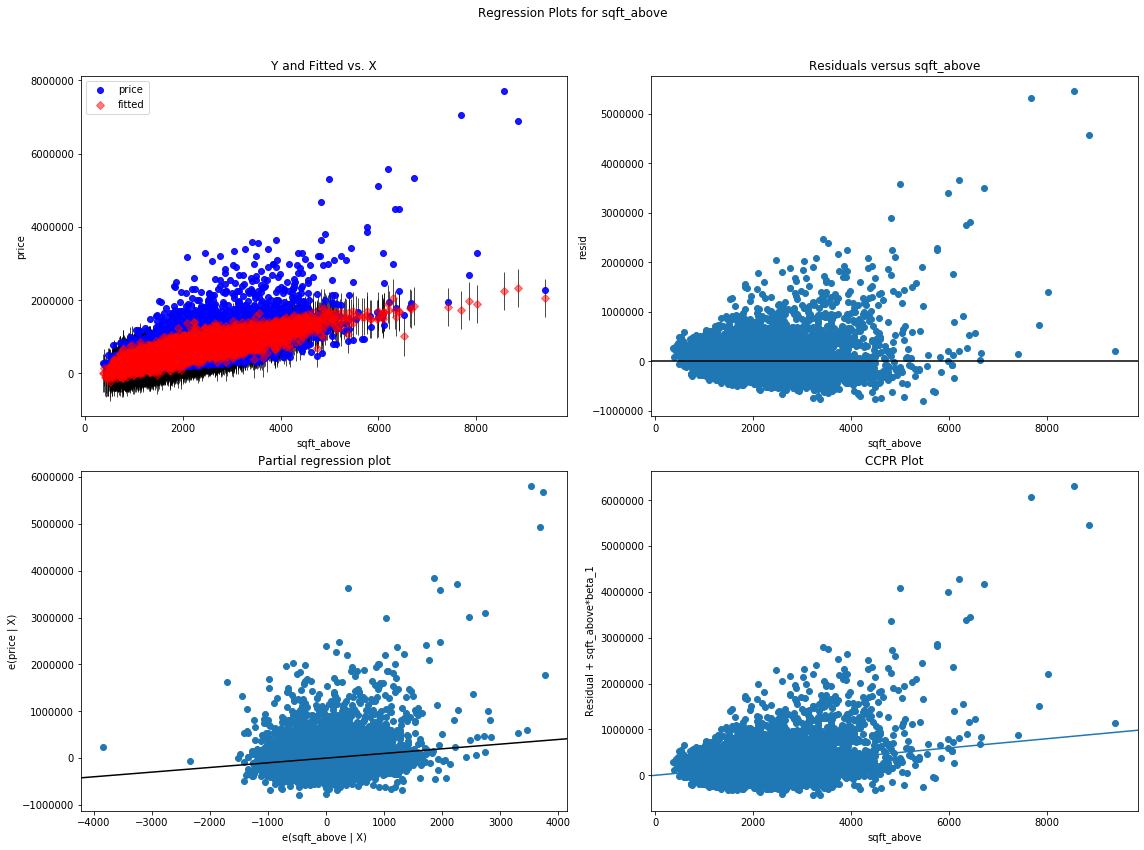

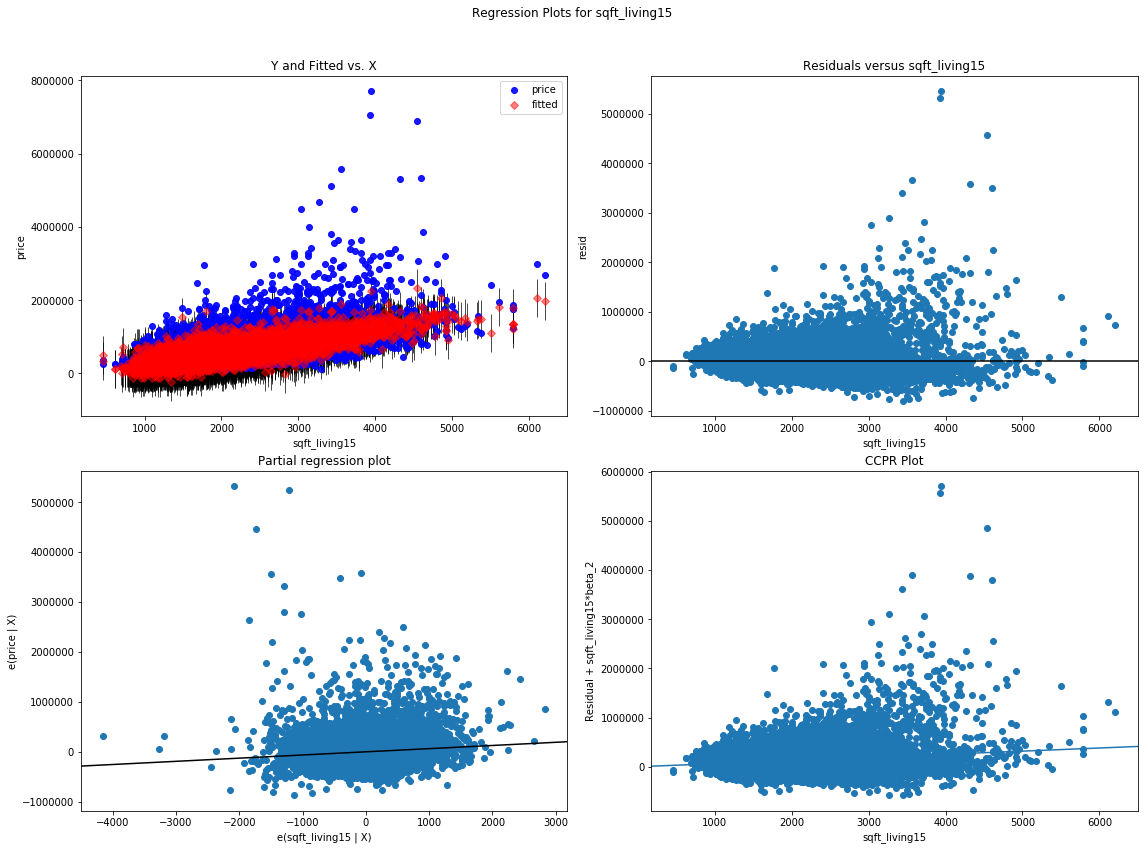

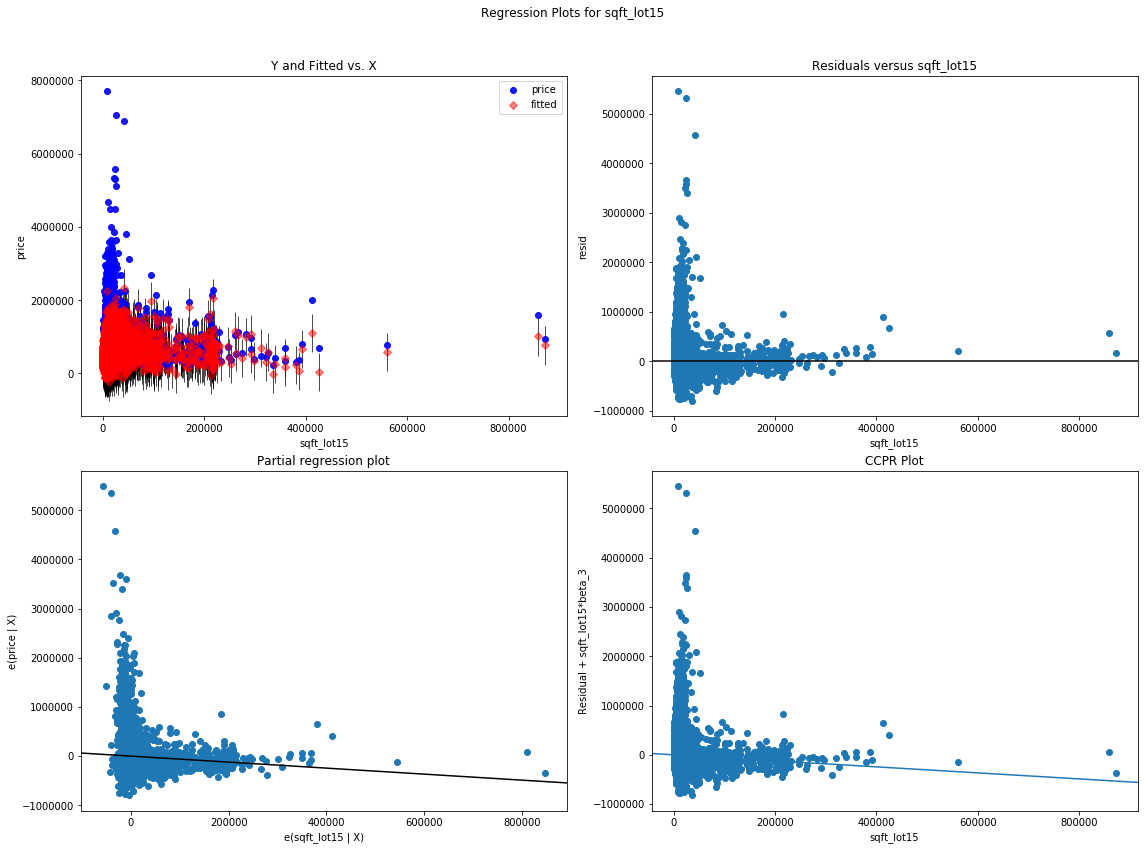

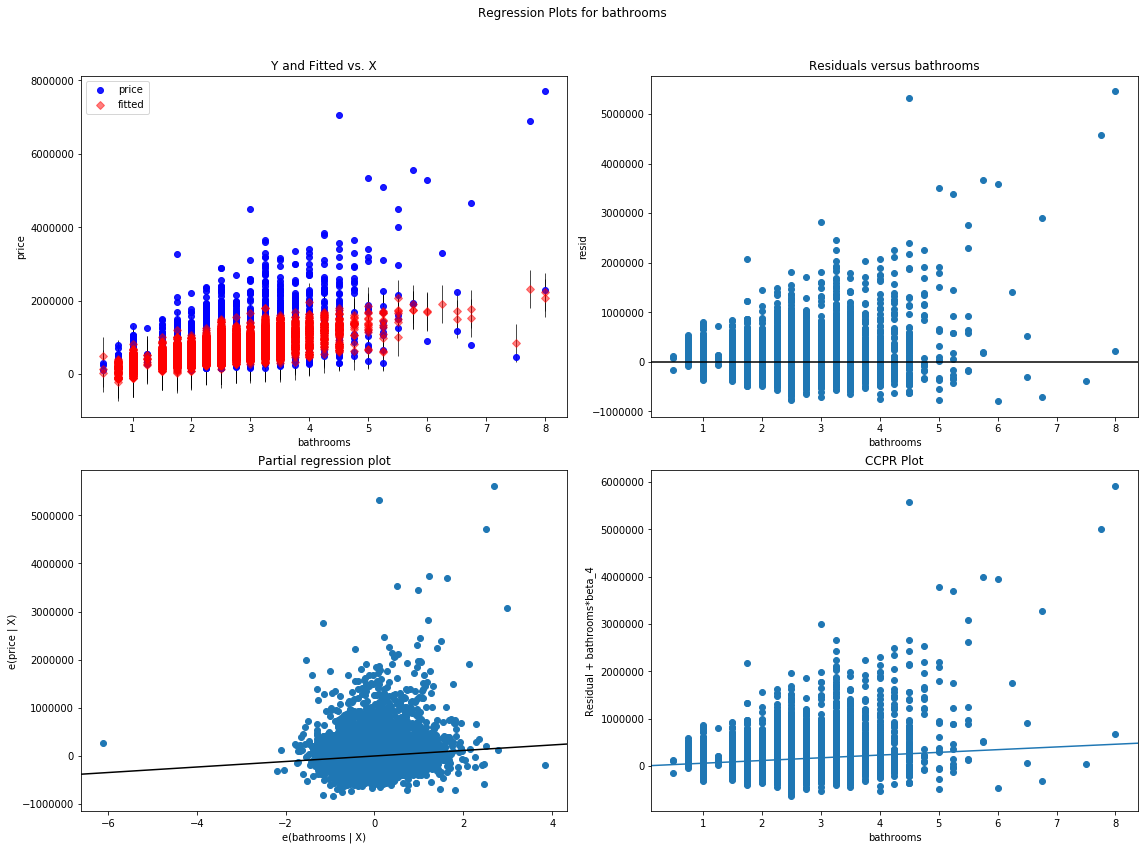

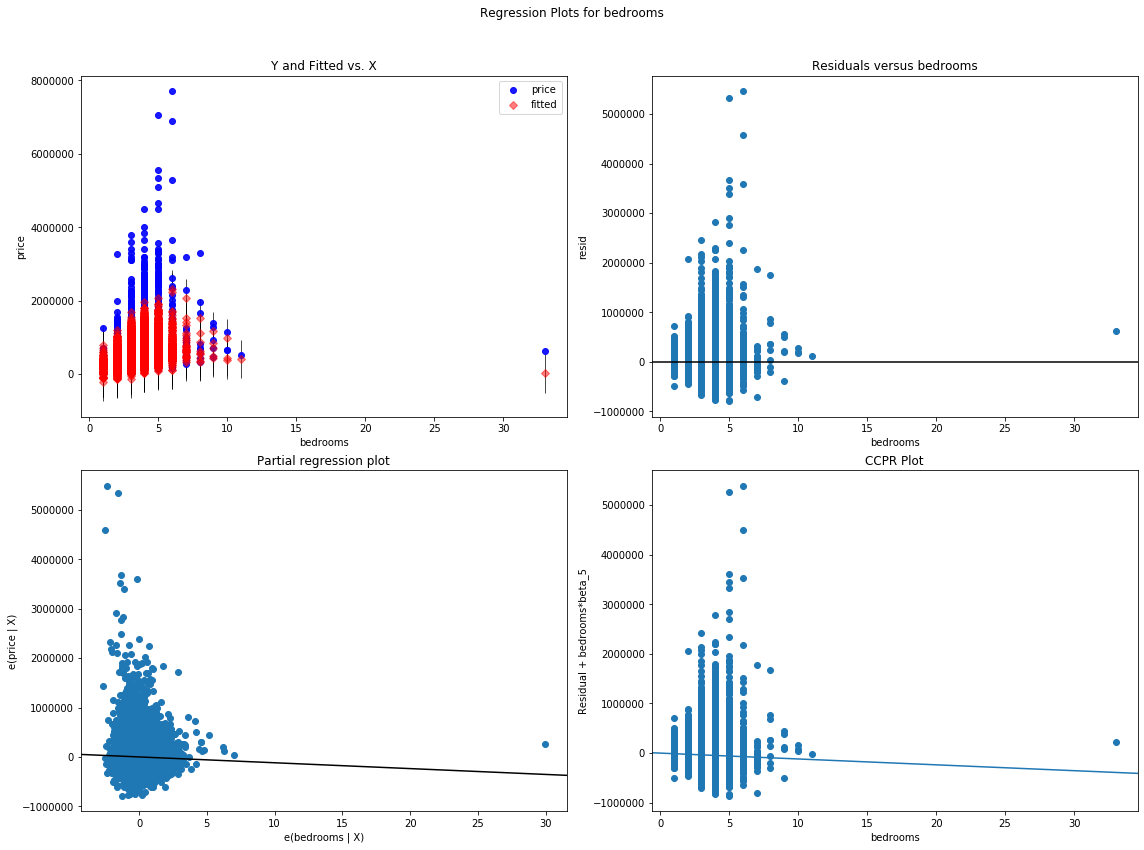

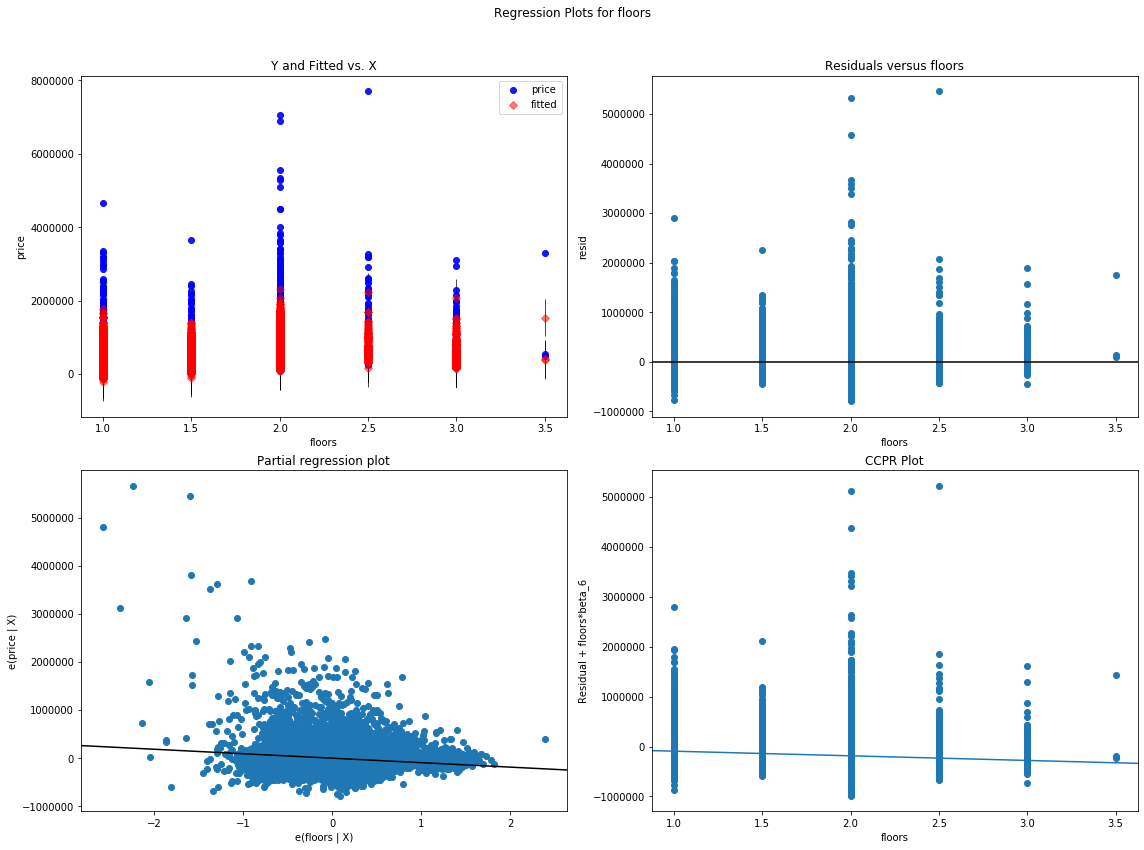

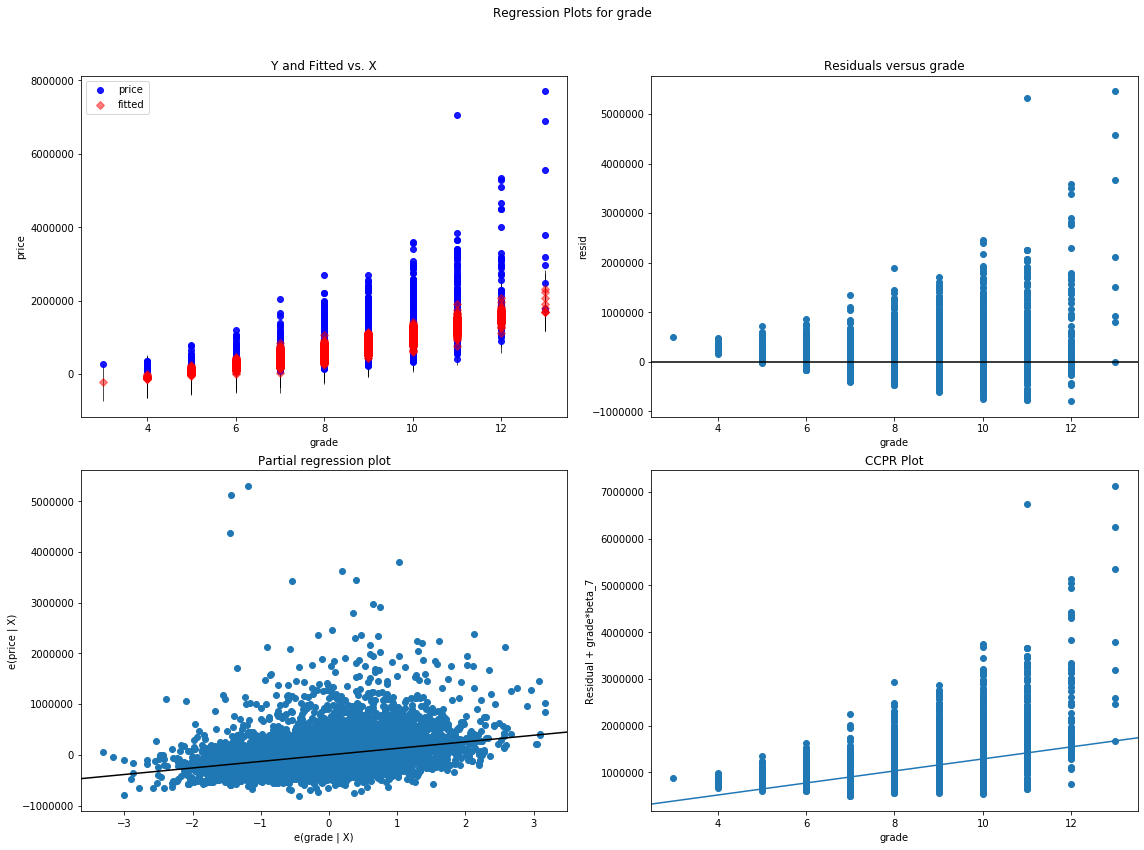

In [68]:

for col in X_train_cont_features.columns:
    fig = plt.figure(figsize=(16,12))
    sm.graphics.plot_regress_exog(model_cont_features, col, fig=fig)
    fig.show()

sqft_above
* correlated with target
* residuals are somewhat homoskedastic, they are close to the mean when the var is low, but increase as sqft approaches 2000 and then remains fairly constant, but with some positive outliers as sqft_above increases. 

**It may be worth removing the extreme outliers and re-checking model fit**.

sqft_living
* correlated with target
* residuals are not homoskedastic.  They are close to the mean when the var is low and increase from there.

sqft_living15
* correlated with target
* residuals are somewhat homoskedastic. Similar to sqft_above. 

**It may be worth removing the extreme outliers and re-checking model fit**

sqft_lot
* not correlated with target
* residuals are not homoskedastic

sqft_lot15
* nor correlated with target
* residuals are not homoskedastic

## Simple Model + Simple Categoricals

This model will contain all the continuous variable and the simple categorical variables

### Define Feature Sets

In [69]:
cols_to_ignore = ['id', 'date', 'zipcode', 'lat', 'long', 'sqft_basement', 
                  'yr_built', 'yr_renovated', 'bathrooms', 'bedrooms']
ssc_cols = [col for col in X_train.columns if col not in cols_to_ignore]

X_train_ssc_features = X_train[ssc_cols]
X_test_ssc_features = X_test[ssc_cols]

**Features to Drop**

sqft_lot had a high p_value

sqft_living had a high multicolinearity with sqft_above, and its residuals with the target were
not homoskedastic

In [70]:
X_train_ssc_features = X_train_ssc_features.drop('sqft_lot', axis=1)
X_test_ssc_features = X_test_ssc_features.drop('sqft_lot', axis=1)

X_train_ssc_features = X_train_ssc_features.drop('sqft_living', axis=1)
X_test_ssc_features = X_test_ssc_features.drop('sqft_living', axis=1)

### Linear Regression sklearn

In [71]:
lin_reg_sklearn(X_train_ssc_features, X_test_ssc_features, y_train, y_test)

Training Set RMSE: 241028.92481006635
Test Set RMSE: 240195.0766260555
Cross Val RMSE: 242161.7840732077


### Linear Regression Statsmodels

In [72]:
X_train_ssc_features_int = sm.add_constant(X_train_ssc_features)
model_ssc_features = sm.OLS(y_train, X_train_ssc_features_int).fit()
model_ssc_features.summary()

/Users/freethrall/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     2105.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:09:04   Log-Likelihood:            -2.3862e+05
No. Observations:               17277   AIC:                         4.773e+05
Df Residuals:                   17265   BIC:                         4.774e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.022e+05    1.9e+04    -47.479      0.000   -9.39e+05   -8.65e+05
floors        -4.701e+04   4261.283    -11.032      0.000   -5.54e+04   -3.87e+04
condition      6.588e+04   2919.932     22.562      0.000    6.02e+04    7.16e+04
grade          1.279e+05   2642.892     48.403      0.000    1.23e+05    1.33e+05
sqft_above      121.4921      4.108     29.572      0.000     113.439     129.545
sqft_living15    37.8670      4.419      8.569      0.000      29.205      46.529
sqft_lot15       -0.7107      0.071    -10.031      0.000      -0.850      -0.572
view__1        1.755e+05   1.53e+04     11.471      0.000    1.46e+05    2.05e+05
view__2        1.299e+05   9071.668     14.323      0.000    1.12e+05    1.48e+05
view__3        2.371e+05   1.23e+04     19.270      0.000    2.13e+05    2.61e+05
view__4        4.207e+05    1.9e+04     22.116      0.000    3.83e+05    4.58e+05
waterfront__1  5.865e+05   2.67e+04     21.984      0.000    5.34e+05    6.39e+05
==============================================================================
Omnibus:                    14529.966   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1492151.458
Skew:                           3.491   Prob(JB):                         0.00
Kurtosis:                      47.989   Cond. No.                     4.81e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Analyze the Residuals

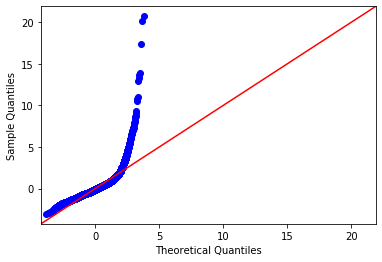

In [73]:
sm.graphics.qqplot(model_cont_features.resid, line='45', fit=True);